# Let the challenge begin

**Notes on data** 

- 5 EEG derivations sampled at 250Hz
- 3 Accelerometers derivations sampled at 50Hz
- Sleep epoch = 30 sec
- hypnogram = succession of the sleep stages (0...5)

**General info sleep**
- Sleep stages = (N1, N2) = light sleep, N3 = deep sleep, REM
- Low frequency power: N3 > N2 > N1-REM-Wake

**Wake**
- During Wake epoch alpha waves are clearly visible on the F-O derivation
- Movement occured mainly during wake periods, noisy signals during movement
- Alpha wave frequency ranges between 8 and 13 hertz = wake, relaxed
**N1**
- Theta waves freq betw 4 and 8 Hz = N1, N2

**N2**
- On N2 epoch, power in the spindle range is much higher on frontal-frontal channels
- Theta waves freq betw 4 and 8 Hz = N1, N2
- During N2, sleep spindles (fast rythm between 12-14Hz which last between 0.5 up to 2 seconds) are more visible on the Frontal-frontal derivation

**N3**
- On N3 epoch, we can see more power in the low frequencies
- Delta waves freq betw 1 and 4 Hz = N3

**REM**
- REM sleep distinguishable with steady EEG and eyes movement which can be seen when looking at Frontal-occipital vs frontal-frontal derivation.
- The EEG power increases in the low-frequency band when the sleep stage change from REM to NREM sleep stages
- REM epoch have more steady EEG

**Formulas**
- Spectrogram are the time-frequency matrix z = P(t, f)
- Spectrum correspond to the curves y = P(frequency)
- Average Spectrum can therefore be computed as the mean of spectromgram over a specified period 

**Links**
https://opentext.wsu.edu/psych105/chapter/stages-of-sleep/
https://www.sleepfoundation.org/how-sleep-works/alpha-waves-and-sleep
https://centralesupelec.edunao.com/pluginfile.php/242107/course/section/36663/Challenge%20Data%20Dreem-1.pdf
https://centralesupelec.edunao.com/pluginfile.php/242107/course/section/36663/entropy-18-00272.pdf



In [1]:
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from os import listdir
from random import randint
import random as rd

from lspopt import spectrogram_lspopt
from scipy.signal import spectrogram

from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA
from sklearn.decomposition import FastICA

from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import plot_confusion_matrix, f1_score
from sklearn.metrics import balanced_accuracy_score, cohen_kappa_score, confusion_matrix

In [2]:
frequency_bands = {
        "delta": [0.5, 4],
        "theta": [4, 8],
        "alpha": [8, 12],
       "sigma": [12, 16],
       "beta": [16, 30]
    }

EEG_FS = 250
ACC_FS = 50 
epoch_s = 30
n_EEG = 5
n_ACC = 3

hypnograms = pd.read_csv('targets_train.csv')

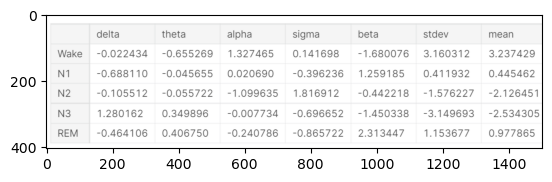

In [3]:
plt.imshow(plt.imread('corr_sleep_stages.png'))

In [4]:
def get_average_spectrum_for_epochs(eeg,epochs):
    """
    Return the average power in each of the fourier bin for several epochs.
    """
    psds = []
    for epoch in epochs:
        idx_start,idx_end = 250 * 30 * epoch,250 * 30 * (epoch + 1)
        freqs,t,psd = spectrogram_lspopt(np.clip(eeg[idx_start:idx_end],-150,150),250,nperseg = 1000)
        psds += [np.mean(psd ** 2,1)]
    return freqs,np.array(psds).mean(0)

In [5]:
## Function to plot N sleep epochs for a specific stage

def random_sleep_epoch(N, sleep_stage, hypnogram) :
    k = 0
    a = randint(0,len(hypnogram))
    epochs = []
    while k < N:
        if hypnogram[a] == sleep_stage :
            epochs.append(a)
            k += 1
            a = randint(0,len(hypnogram))
        else :
            a = randint(0,len(hypnogram))
    eeg_ff = np.load('sample/sample/f8_f7.npy')
    for epoch in epochs : 
        t0 = epoch*epoch_s*EEG_FS
        eeg_short = eeg_ff[t0:t0+(epoch_s*EEG_FS)]
        plt.figure(figsize=(25, 8))
        plt.plot(eeg_short)
        plt.ylim([-200, 200])
        plt.xlim(0,len(eeg_short))
        plt.show()

## Mélina important

In [6]:
frequency_bands = {
        "delta": [0.5, 4],
        "theta": [4, 8],
        "alpha": [8, 12],
       "sigma": [12, 16],
       "beta": [16, 30]
    }

EEG_FS = 250
ACC_FS = 50 
epoch_s = 30
n_EEG = 5
n_ACC = 3

hypnograms = pd.read_csv('targets_train.csv')


def split_train_test(records, split=0.5) : 
    rd.seed(1234)
    rd.shuffle(records)
    k = int(len(records)*split)
    return records[:k],records[k:]


def spectral_power(data,n,fs) :
    for i in range (n) :
        sfreqs,t,psd = spectrogram(data[:,i,:], fs, nperseg = 1000,noverlap = 750)
        psd = np.mean(np.abs(psd),-1)
        l = []
        for name, freqband in frequency_bands.items():
            spec_power = psd[:,(sfreqs >= freqband[0]) & (sfreqs < freqband[1])]
            spec_power = np.sum(spec_power, 1)
            l.append(spec_power / np.sum(psd,1))
        matrice = np.array(l) 
        matrice = np.vstack((matrice, np.array([np.mean(data[k,i,:]) for k in range (len(data))]).T))
        matrice = np.vstack((matrice, np.array([np.std(data[k,i,:]) for k in range (len(data))]).T))
        if i == 0:
            complete_array = matrice 
        else :
            complete_array = np.vstack((complete_array,matrice))
    return(complete_array.T)

def correlations(record, data, n) :
    corr = [0]*n
    for i in range (n) :
        corr[i] = [0]*n
        for j in range (n) :
            corr[i][j] = np.corrcoef(data[record,i,:], data[record,j,:])[0][1]
        print(i+1,corr[i]) 
    return corr  

def whitening(X):  
    cov = np.cov(X)
    d, E = np.linalg.eigh(cov)
    D = np.diag(d)
    D_inv = np.sqrt(np.linalg.inv(D))
    X_whiten = np.dot(E, np.dot(D_inv, np.dot(E.T, X)))
    return X_whiten

In [7]:
class preprocessing() :
    def __init__(self, record):
        if type(record) == list:
            self.data = np.load(f'training_records/{record[0]}')
            record_number = int(record[0][-5])
            self.hypnogram = list(hypnograms[hypnograms['record'] == record_number]['target'])
            self.record = [record[0]]
            for r in range(1,len(record)):
                record_number = int(record[r][-5])
                h = list(hypnograms[hypnograms['record'] == record_number]['target'])
                self.hypnogram.extend(h)
                d = np.load(f'training_records/{record[r]}')
                self.data = np.vstack((self.data,d))
                self.record.append(record[r])

    def EEG_ACC(self) :
        EEG = self.data[:,1:EEG_FS * epoch_s * n_EEG + 1]
        self.EEG = EEG.reshape(len(self.data), n_EEG, EEG_FS * epoch_s)
        ACC = self.data[:,EEG_FS * epoch_s * n_EEG + 1:]
        self.ACC = ACC.reshape(len(self.data), n_ACC, ACC_FS * epoch_s)

    def EEG_spectral(self) :
        self.EEG_ACC()
        self.EEG_spectral_power = spectral_power(self.EEG,n_EEG,EEG_FS)

    def ACC_spectral(self) :
        self.EEG_ACC()
        self.ACC_spectral_power = spectral_power(self.ACC,n_ACC,ACC_FS)
    
    def EEG_and_ACC_spectral(self) : 
        self.EEG_ACC()
        self.EEG_spectral()
        self.ACC_spectral()
        self.EEG_and_ACC_spectral_power = np.vstack(((self.EEG_spectral_power).T, (self.ACC_spectral_power).T))
        self.data= self.EEG_and_ACC_spectral_power.T
        variable_list = []
        stats = 'mean', 'std'
        data = 'EEG', 'ACC'
        len_data = n_EEG, n_ACC
        for d in range (len(data)) : 
            for n in range (len_data[d]) :
                for freq in list(frequency_bands) : 
                    variable_list.append(f"{data[d]}_{n+1}_{freq}")
                for stat in stats :
                    variable_list.append(f"{data[d]}_{n+1}_{stat}")
        self.variable_list = variable_list

    def norm(self) :
        self.data = normalize(self.data)

    def pca_data(self, n=None) :
        if n > 1 : 
            solver = 'arpack'
        else :
            solver = 'auto'
        pca = PCA(random_state=42, svd_solver=solver, n_components=n)
        self.data = pca.fit_transform(self.data)

    def ica_data(self, n=None):
        self.data = whitening(self.data)
        ica = FastICA(random_state=42, n_components=n, whiten=False)
        self.data = ica.fit_transform(self.data)
    
    def corr_EEG(self) :
        self.EEG_ACC()
        self.cross_corr_EEG = correlations(self.record, self.EEG, n_EEG)

    def corr_ACC(self) :
        self.EEG_ACC()
        self.cross_corr_ACC = correlations(self.record, self.ACC, n_ACC)

In [8]:
types = 'train', 'test'
records_list = listdir("training_records")
records = {}
records[types[0]], records[types[1]] = split_train_test(records_list, split=0.5)
obj = {}
x = {}
y = {}
for t in types:
    obj[t] = preprocessing(records[t])
    obj[t].norm()
    obj[t].pca_data(n=40)
    x[t] = obj[t].data
    y[t] = obj[t].hypnogram

In [9]:
class machine_learning() :
    def __init__(self, x,y):
        self.x_train = x['train']
        self.y_train = y['train']
        self.x_test = x['test']
        self.y_test= y['test']
        self.predictions_by_model = {}
        self.available_models = 'random_forest', 'SVM', 'KNN', 'multi_layer_perceptron', 'decision_tree'

    def training(self, object) :
        print('training...')
        object.fit(self.x_train, self.y_train)   
        self.predictions = object.predict(self.x_test)

    def random_forest(self, n_estimators=100, max_depth=None) :
        clf_rf = RandomForestClassifier(random_state=42, n_estimators=n_estimators, max_depth=max_depth)
        self.training(clf_rf)
        self.predictions_by_model['random_forest'] = self.predictions

    def svm_svc(self) :
        svc = SVC(random_state = 42) 
        self.training(svc)
        self.predictions_by_model['SVM'] = self.predictions

    def KNN(self,n=10) : 
        knn = KNeighborsClassifier(n_neighbors=n) 
        self.training(knn)
        self.predictions_by_model['KNN'] = self.predictions

    def multi_layer(self):
        mlp = MLPClassifier()
        self.training(mlp)
        self.predictions_by_model['multi_layer_perceptron'] = self.predictions

    def Dtree(self) :
        tree = DecisionTreeClassifier()
        self.training(tree)
        self.predictions_by_model['decision_tree'] = self.predictions

    def democratic(self) :
        self.random_forest()
        self.svm_svc()
        self.KNN()
        self.multi_layer()
        self.Dtree()
        for i in range(len(self.predictions)) :
            labels = [0]*5
            for model in self.available_models:
                labels[self.predictions_by_model[model][i]] += 1
            self.predictions[i] = labels.index(max(labels))
    
    def scoring(self) :
        self.scores = {'balanced_accuracy': balanced_accuracy_score(self.y_test, self.predictions),
            'cohen_kappa': cohen_kappa_score(self.y_test, self.predictions),
            'macro_f1': f1_score(self.y_test, self.predictions,average ='macro')}

    def confus_mat(self) :
        ConfusionMatrixDisplay.from_predictions(self.y_test, self.predictions)
        plt.show()


training...
training...
training...
training...


c:\Users\melin\mne-python\1.2.1_0\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


training...


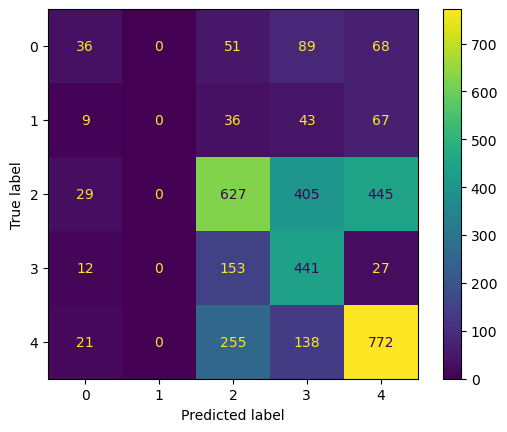

{'balanced_accuracy': 0.38229711935371213, 'cohen_kappa': 0.29850544533594614, 'macro_f1': 0.3577069274608418}


In [10]:
ML = machine_learning(x,y)
ML.democratic()
ML.scoring()
ML.confus_mat()
print(ML.scores)

TODO: 
- include all EEG / accelerometer? channels
    - for EEG: do spectral analysis for each channel
    - think about what to do with accelerometer channels 

change variable names

https://github.com/Kaggle/kaggle-api

VERY LATER: take training data and test data already cut  / for now keep this division

# Random forest classifier

training...
{'balanced_accuracy': 0.432552411985703, 'cohen_kappa': 0.34918807043206934, 'macro_f1': 0.409040924758089}


c:\Users\melin\mne-python\1.2.1_0\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


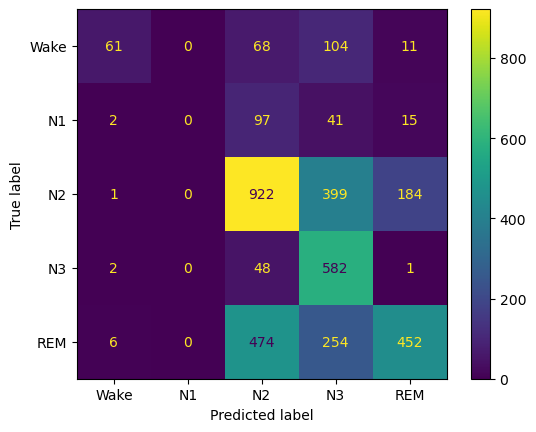

In [21]:
# run decision tree

clf_rf = RandomForestClassifier(random_state=42)
print('training...')
clf_rf.fit(x_train.data, y_train)

# test it
predictions = clf_rf.predict(x_test.data)
scores = {'balanced_accuracy': balanced_accuracy_score(y_test, predictions),
            'cohen_kappa': cohen_kappa_score(y_test, predictions),
            'macro_f1': f1_score(y_test, predictions,average ='macro')}

print(scores)
plot_confusion_matrix(clf_rf, x_test.data, y_test, display_labels = ['Wake','N1','N2','N3','REM'])
plt.show()

In [ ]:
# import sklearn

# metrics = "balanced_accuracy","f1_macro"

# sklearn.model_selection.cross_validate(clf_rf, X_train, y_train, scoring=metrics)

# clf_rf

### Evaluate importance of each parameter: Permutation importance

In [ ]:
print('permutations...')
from sklearn.inspection import permutation_importance
# We use the build-in sklearn fontion to compute the permutation importance
result = permutation_importance(clf_rf, ML_data.x_test, y_test, n_repeats=50, random_state=0,scoring = 'f1_macro')
sorted_idx = result.importances_mean.argsort()

# And plot the importance of each variable
fig, ax = plt.subplots(figsize=(25, 10))
ax.boxplot(result.importances[sorted_idx].T,
           vert=False, labels=variable_list)
ax.set_title("Permutation Importances (Test set)")
plt.xlabel('Decrease in Macro-F1')
fig.tight_layout()
plt.show()

In [ ]:
f1 = []
for k in range (len(variable_list)) : 
    X_train_k = X_train.copy()
    X_train_k = np.delete(X_train_k, k, 1)
    X_test_k = X_test.copy()
    X_test_k = np.delete(X_test_k, k, 1)
    clf_rf.fit(X_train_k, y_train)
    predictions = clf_rf.predict(X_test_k)
    f1.append(f1_score(y_test, predictions,average ='macro'))


In [ ]:
plt.plot(f1)
f1_order = np.argsort(np.array(f1))
f1_sorted = [f1[i] for i in f1_order]
print(f1_order)
print(f1_sorted)
variables_sorted = [variable_list[i] for i in f1_order]
print(variables_sorted)

In [ ]:
plt.plot(f1)
f1_order = np.argsort(np.array(f1))
f1_sorted = [f1[i] for i in f1_order]
print(f1_order)
print(f1_sorted)
variables_sorted = [variable_list[i] for i in f1_order]
print(variables_sorted)

Spectral components have a very marginal effect on classification -> to be improved

Todo: implement cross validation and compare with no cross validation
check if CV useful with random 
MAJOR CHANGE

TODO: plot test error for CV/test set

# DEEP LEARNING OH YEAH

## (temporary) load single channel data

In [ ]:
data_for_records = {}
hypnogram_for_records = {}
hypnograms = pd.read_csv('targets_train.csv')
for record in listdir("training_records"):
    record_number = int(record[-5])
    x = np.load(f'training_records/{record}')
    data_for_records[record] = x[:,1:250 * 30 + 1]
    hypnogram_for_records[record] = list(hypnograms[hypnograms['record'] == record_number]['target'])

In [ ]:
rd.seed(1234)
records_list = list(data_for_records)
rd.shuffle(records_list)
training_record,test_records = records_list[:5],records_list[5:]

print('Training records: ',training_record)
print('Test records: ', test_records)

In [ ]:
def build_dataset(records, data_for_records,hypnogram_for_records):
    X,y = [],[]
    for record in records:
        X.append(data_for_records[record])
        y.extend(hypnogram_for_records[record])

    return np.concatenate(X),y


X_train,y_train = build_dataset(training_record,data_for_records,hypnogram_for_records)
X_test,y_test = build_dataset(test_records,data_for_records,hypnogram_for_records)



define load functions 

In [ ]:
""" Load project data
    DataLoader and Dataset for single-channel EEG

"""

import torch
from torch.utils.data import Dataset, DataLoader


def normalize_data(eeg_array):
    """normalize signal between 0 and 1"""

    normalized_array = np.clip(eeg_array, -250, 250)
    normalized_array = normalized_array / 250

    return normalized_array


class EegEpochDataset(Dataset):
    """EEG Epochs dataset."""

    def __init__(self, x_data, y_data, transform=None):
        """
        Args:
            x_data (numpy array): Numpy array of input data.
            y_data (list of numpy array): Sleep Stages
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.y_data = y_data
        self.x_data = x_data
        self.transform = transform

        self.x_data = normalize_data(x_data)

    def __len__(self):
        return len(self.y_data)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        signal = np.expand_dims(self.x_data[idx], axis=0)
        stage = self.y_data[idx]

        if self.transform:
            signal = self.transform(signal)

        return signal, stage


training_dataset = EegEpochDataset(X_train,y_train)
training_dataloader = DataLoader(training_dataset,batch_size = 32)
validation_dataset = EegEpochDataset(X_test,y_test)
validation_dataloader = DataLoader(validation_dataset,batch_size = 32)

First CNN model
+ max pooling

In [ ]:
import torch
import torch.nn as nn


class SingleChannelConvNet(nn.Module):

    def __init__(self):
        super(SingleChannelConvNet, self).__init__()
        self.conv_a = nn.Conv1d(1, 8, 25, stride=5)
        self.conv_b = nn.Conv1d(8, 16, 10, stride=5)
        self.conv_c = nn.Conv1d(16, 32, 10, stride=5)
        self.conv_d = nn.Conv1d(32, 64, 10, stride=5)

        self.relu = nn.ReLU()

        self.fc1 = nn.Linear(64, 5)

    def forward(self, x):

        x = self.relu(self.conv_a(x))
        x = self.relu(self.conv_b(x))
        x = self.relu(self.conv_c(x))
        x = self.relu(self.conv_d(x))
        x = x.max(-1)[0]
        x = self.fc1(x)

        return x


training

* implement early stopping to avoid overfitting

In [ ]:
class EarlyStopper:
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = np.inf

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

https://stackoverflow.com/questions/71998978/early-stopping-in-pytorch

In [ ]:
import torch.optim as optim

# device: use GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# parameters
n_epoch = 80
learning_rate = 1e-3

early_stopper = EarlyStopper(patience=3, min_delta=10)

# neural network and co
my_net = SingleChannelConvNet()
my_net = my_net.to(device) # model into GPU
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(my_net.parameters())
my_net.train()
print('training...')
for epoch in range(n_epoch):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(training_dataloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs, labels = inputs.to(device).float(), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()
        # forward + backward + optimize
        outputs = my_net.forward(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
    print('epoch %d, %d samples, loss: %.3f' % (epoch + 1, (i+1)*training_dataloader.batch_size,running_loss / (i+1)))
    if early_stopper.early_stop(running_loss):             
        break
    running_loss = 0.0

print('Finished Training')


In [ ]:
from sklearn.metrics import balanced_accuracy_score, cohen_kappa_score, confusion_matrix
from sklearn.metrics import plot_confusion_matrix, f1_score
# params
classes = ['Wake', 'N1', 'N2', 'N3', 'REM']

with torch.no_grad():
    prediction_list = torch.empty(0).to(device)
    true_list = torch.empty(0).to(device)
    for data in validation_dataloader:
        inputs, labels = data
        inputs, labels = inputs.to(device).float(), labels.to(device)
        
        outputs = my_net(inputs)
        _, predicted = torch.max(outputs, 1)
        prediction_list = torch.cat([prediction_list, predicted])
        true_list = torch.cat([true_list, labels])

true_list = true_list.cpu().numpy()
prediction_list = prediction_list.cpu().numpy()
scores = {'balanced_accuracy': balanced_accuracy_score(true_list, prediction_list),
            'macro_f1': f1_score(true_list, prediction_list, average = 'macro'),
            'confusion_matrix': confusion_matrix(true_list, prediction_list)}

for elt in scores:
    print(elt)
    print(scores[elt])